# RETAIL FORECASTING PROJECT

|Group Name | Projection Wizard  |
|-----------|-----------|
| Name | Hande Gul atasagun |
| Email | hgatasagun@outlook.com |
| Country | Turkey |
| Specialization | Data Science |


### Problem description:

A large beverage company operating in the Australian market faces challenges in demand forecasting for its wide range of products. The demand is subject to fluctuations influenced by various factors, including holidays, seasonality, and promotional activities. The company is currently using an in-house forecasting software, which often produces unreliable and nonsensical forecasts. In pursuit of more accurate and efficient forecasting, the company aims to explore the potential of AI/ML-based solutions to replace their existing in-house system.

### Dataset understanding:

The dataset provided is a collection of historical sales data for company's products. The dataset comprises data recorded from February 5, 2017, to December 27, 2020. The data includes the following columns:

- **Product:** Product name.
- **Date:** Dates on which sales data were recorded weekly.
- **Sales:** The number of units sold weekly.
- **Price Discount (%):** The percentage of discount applied to the product's price during that week.
- **In-Store Promo:** Indicates the presence of in-store promotions (1 for yes, 0 for no) during the week.
- **Catalogue Promo:** ndicates the presence of catalogue promotions (1 for yes, 0 for no) during the week.
- **Store End Promo:** Indicates the presence of store end promotions (1 for yes, 0 for no) during the week.
- **Google_Mobility:** Data reflecting the impact of Google Mobility on sales.
- **Covid_Flag:** A flag representing the influence of COVID-19 on sales.
- **V_DAY, EASTER, CHRISTMAS:** Indicators of specific holiday or event occurrences and their impact on sales during the week.


## 1. Importing Required Libraries and Dataset

### 1.1. Importing libraries:

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import lightgbm as lgb
import warnings
import re
from IPython.display import display, HTML
from datetime import datetime

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 500)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
warnings.filterwarnings('ignore')

### 1.2. Reading datasets:

In [2]:
df = pd.read_excel('/Users/handeatasagun/PycharmProjects/forecasting_case_study.xlsx')

In [3]:
# Cleaning column names
#######################

def clean_column_names(df):
    df.columns = df.columns.str.replace('[^a-zA-Z0-9]+', ' ', regex=True)
    df.columns = df.columns.str.strip()
    df.columns = df.columns.str.replace(' ', '_', regex=True)
    df.columns = df.columns.str.replace('__+', '_', regex=True)
    df.columns = df.columns.str.lower()
    return df.head(3)


In [4]:
clean_column_names(df)

,product,date,sales,price_discount,in_store_promo,catalogue_promo,store_end_promo,google_mobility,covid_flag,v_day,easter,christmas
0,SKU1,2017-02-05,27750,0.000,0,0,0,0.000,0,0,0,0
1,SKU1,2017-02-12,29023,0.000,1,0,1,0.000,0,1,0,0
2,SKU1,2017-02-19,45630,0.170,0,0,0,0.000,0,0,0,0


## 2. Data Understanding

### 2.1. Time period:

In [5]:
df['date'].min(), df['date'].max()

(Timestamp('2017-02-05 00:00:00'), Timestamp('2020-12-27 00:00:00'))

### 2.2. Data frame inspection function:

In [6]:
def check_df(dataframe, head=5):
    display(HTML(f"<h3>Types</h3>{dataframe.dtypes.to_frame().to_html()}"))
    display(HTML(f"<h3>Head</h3>{dataframe.head(head).to_html()}"))
    display(HTML(f"<h3>Shape</h3>{dataframe.shape}"))
    display(HTML(f"<h3>NA</h3>{dataframe.isnull().sum().to_frame().to_html()}"))
    display(HTML(f"<h3>Quantiles</h3>{dataframe.describe([0.25, 0.50, 0.95]).T.to_html()}"))

- The dataset contains 1218 rows and 12 columns.
- No missing values are present in the dataset.
- Sales column has a minimum value of 0 and a maximum value of 288,322. The average value is 30,294. The values being 0 may suggest the presence of missing data.
- On products, an average of 25% price discount was applied, with the highest discount being 83%.
- Among the types of promotions, it has been observed that in-store promotion (0.472) is applied the most.
- According to the Google mobility data, the average mobility index is relatively low, indicating limited mobility activities.

In [7]:
check_df(df)

,0
product,object
date,datetime64[ns]
sales,int64
price_discount,float64
in_store_promo,int64
catalogue_promo,int64
store_end_promo,int64
google_mobility,float64
covid_flag,int64
v_day,int64


,product,date,sales,price_discount,in_store_promo,catalogue_promo,store_end_promo,google_mobility,covid_flag,v_day,easter,christmas
0,SKU1,2017-02-05,27750,0.000,0,0,0,0.000,0,0,0,0
1,SKU1,2017-02-12,29023,0.000,1,0,1,0.000,0,1,0,0
2,SKU1,2017-02-19,45630,0.170,0,0,0,0.000,0,0,0,0
3,SKU1,2017-02-26,26789,0.000,1,0,1,0.000,0,0,0,0
4,SKU1,2017-03-05,41999,0.170,0,0,0,0.000,0,0,0,0


,0
product,0
date,0
sales,0
price_discount,0
in_store_promo,0
catalogue_promo,0
store_end_promo,0
google_mobility,0
covid_flag,0
v_day,0


,count,mean,min,25%,50%,95%,max,std
date,1218,2019-01-13 02:04:08.275862016,2017-02-05 00:00:00,2018-01-21 00:00:00,2019-01-13 00:00:00,2020-10-11 00:00:00,2020-12-27 00:00:00,NaN
sales,1218.000,30294.679,0.000,7212.750,19742.000,86152.300,288322.000,35032.527
price_discount,1218.000,0.251,0.000,0.020,0.250,0.670,0.830,0.215
in_store_promo,1218.000,0.472,0.000,0.000,0.000,1.000,1.000,0.499
catalogue_promo,1218.000,0.213,0.000,0.000,0.000,1.000,1.000,0.409
store_end_promo,1218.000,0.349,0.000,0.000,0.000,1.000,1.000,0.477
google_mobility,1218.000,-2.377,-28.490,0.000,0.000,0.000,3.900,5.806
covid_flag,1218.000,0.227,0.000,0.000,0.000,1.000,1.000,0.419
v_day,1218.000,0.020,0.000,0.000,0.000,0.000,1.000,0.139
easter,1218.000,0.020,0.000,0.000,0.000,0.000,1.000,0.139


### 2.3. Detecting dataframe column types function:

This function analyzes the columns in a dataframe and determines categorical, numerical, and other columns.

Parameters:
- cat_th (int): Threshold value for considering a column as categorical.
- car_th (int): Threshold value for considering a column as having high cardinality.

In [8]:
def grab_col_names(dataframe, cat_th=10, car_th=20):

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() >= car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    
    return cat_cols, num_cols, cat_but_car

cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 1218
Variables: 12
cat_cols: 8
num_cols: 4
cat_but_car: 0
num_but_cat: 7


- 

### 2.4. Categorical column summary function

The function visualizes the frequency and percentage of a categorical column.

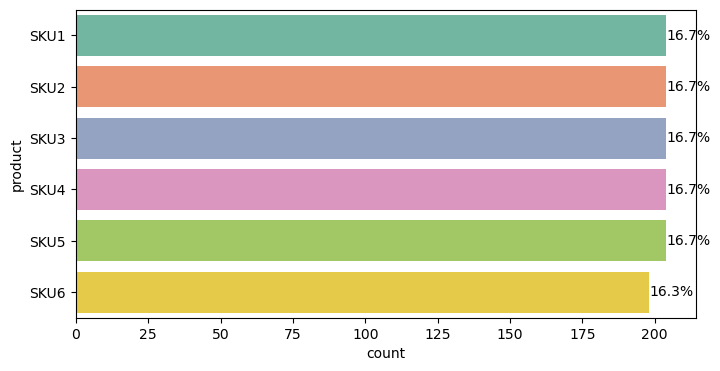

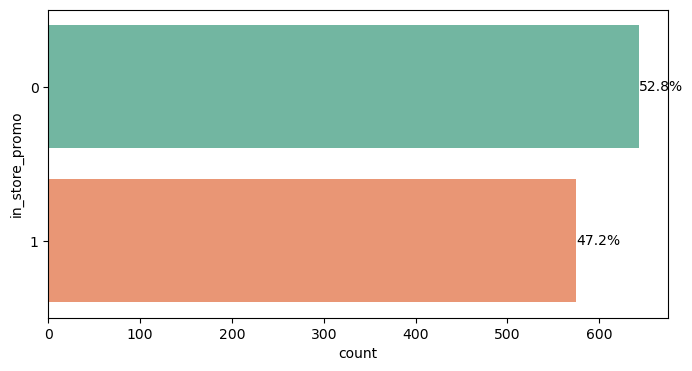

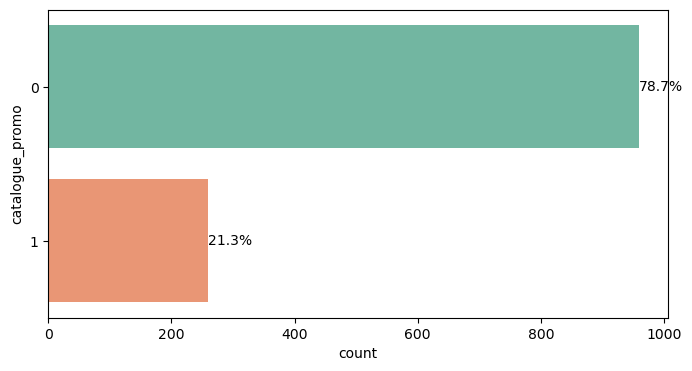

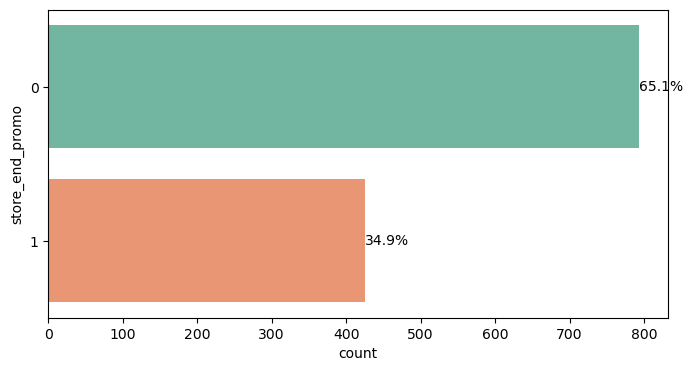

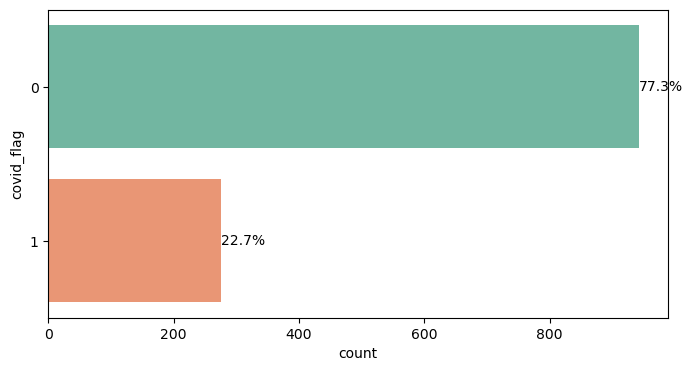

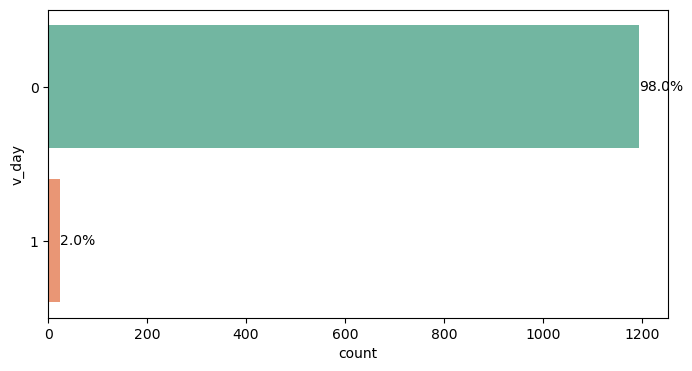

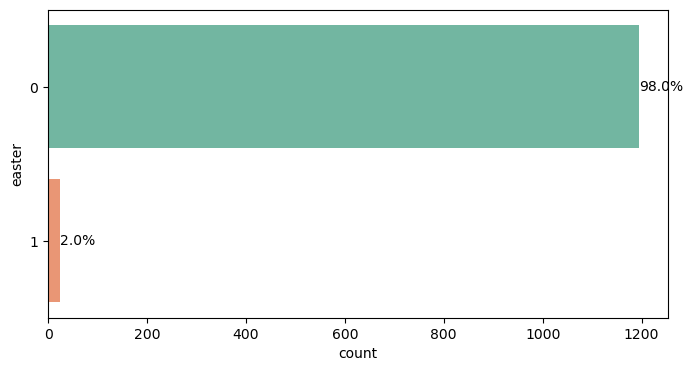

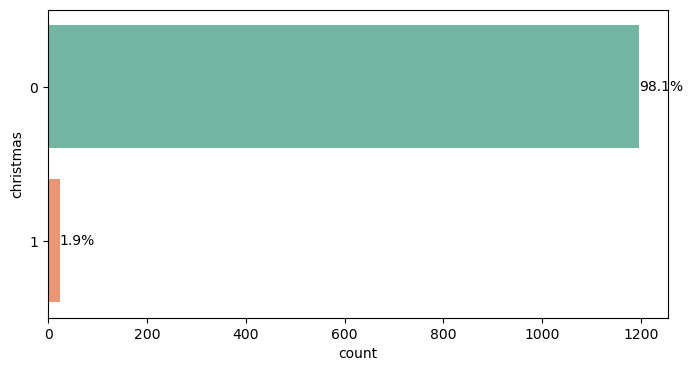

In [9]:
def cat_summary(dataframe, col_name, plot=False):
    if plot:
        sns.set_palette("Set2")
        plt.figure(figsize=(8, 4))
        ax = sns.countplot(y=col_name, data=dataframe, order=dataframe[col_name].value_counts().index)
        
        for p in ax.patches:
            width = p.get_width()
            ax.annotate(f'{width / len(dataframe) * 100:.1f}%', (width, p.get_y() + p.get_height() / 2.),
                        ha='left', va='center')
        
        plt.show(block=True)
        
for col in cat_cols:
    cat_summary(df, col, plot=True)

### 2.5. Numerical column summary function

The function visualizes the frequency and percentage of a numerical column.

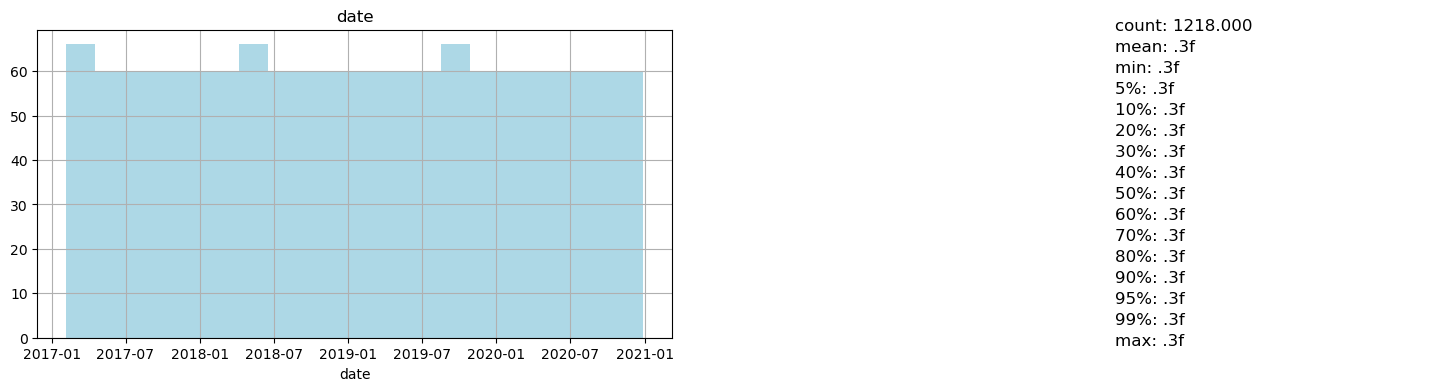

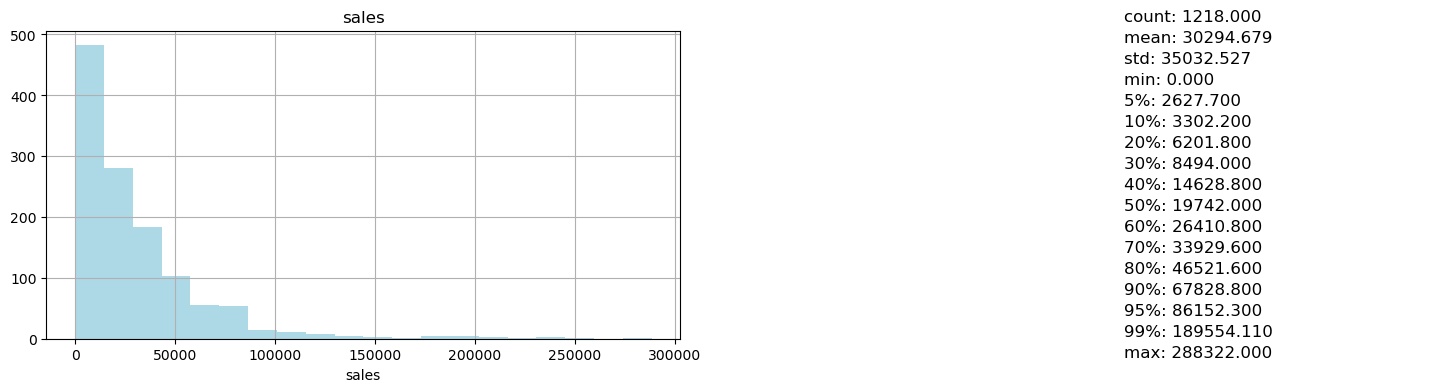

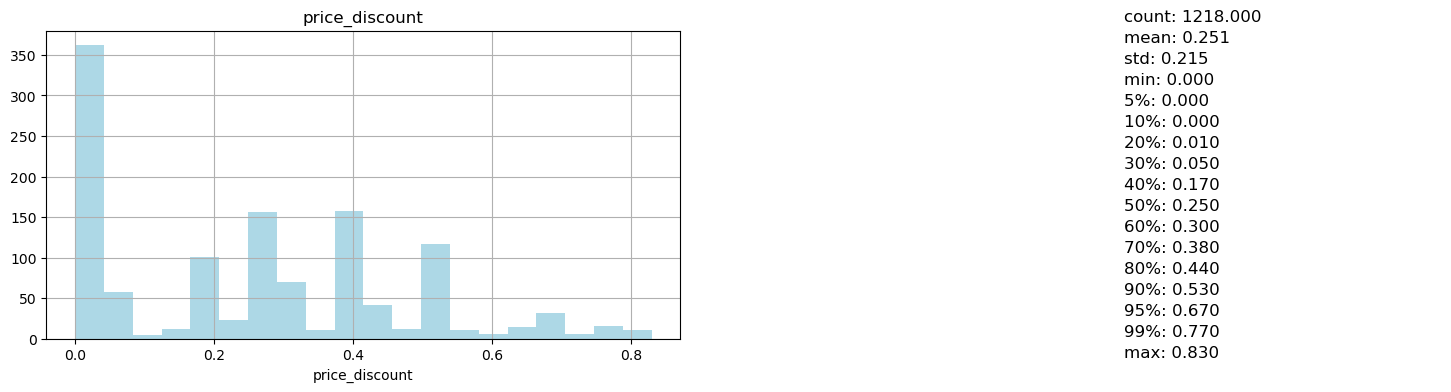

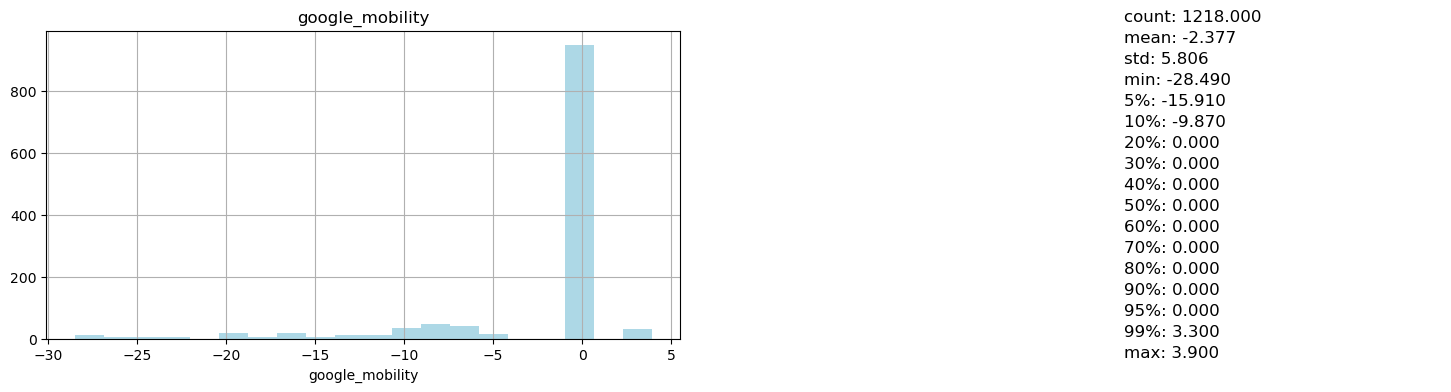

In [10]:
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    summary = dataframe[numerical_col].describe(quantiles)

    if plot:
        fig, axes = plt.subplots(1, 2, figsize=(18, 4))
        
        # Plot histogram
        dataframe[numerical_col].hist(bins=20, ax=axes[0], color="lightblue")
        axes[0].set_xlabel(numerical_col)
        axes[0].set_title(numerical_col)
        
        # Display summary statistics as text
        summary_text = "\n".join([f'{col}: {value:.3f}' for col, value in summary.items()])
        axes[1].text(0.5, 0.5, summary_text, fontsize=12, va='center', ha='left', linespacing=1.5)
        axes[1].axis('off')  # Hide axis for the summary table
        
        plt.show()
        
for col in num_cols:
    num_summary(df, col, plot = True)

### 2.6. Total sales by product:

In [11]:
products = df['product'].unique()
print(products)

['SKU1' 'SKU2' 'SKU3' 'SKU4' 'SKU5' 'SKU6']


- The dataset contains historical data for a total of 6 products.

In [12]:
total_sales = df.groupby('product').agg({'sales':'sum'})

print(total_sales)

            sales
product          
SKU1      9694468
SKU2      1490152
SKU3     11390081
SKU4      3463211
SKU5      3360089
SKU6      7500918


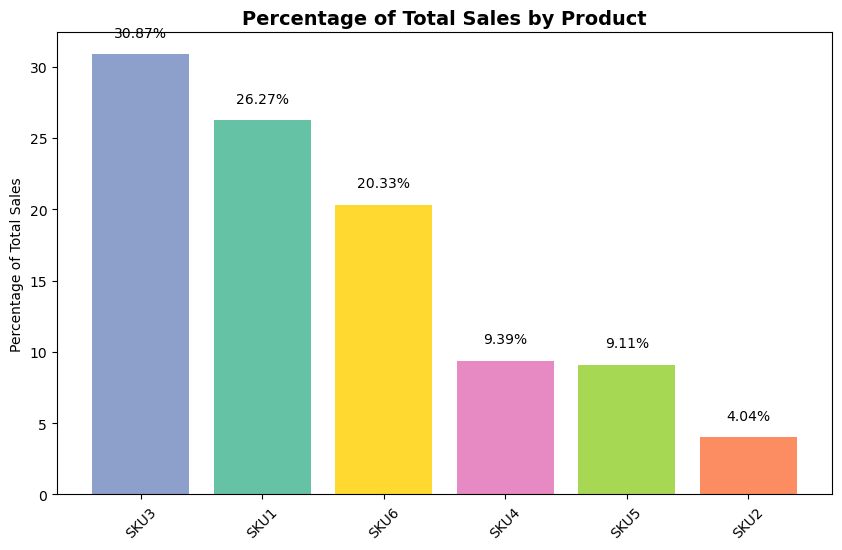

In [13]:
# Creating a graph 
###################

prds = total_sales.index.tolist()

percentages = (total_sales['sales'] / total_sales['sales'].sum() * 100).tolist()

colors = sns.color_palette("Set2")

sorted_data = sorted(zip(prds, percentages, colors), key=lambda x: x[1], reverse=True)
prds, percentages, colors = zip(*sorted_data)

plt.figure(figsize=(10, 6))
bars = plt.bar(prds, percentages, color=colors)
plt.ylabel("Percentage of Total Sales")
plt.title("Percentage of Total Sales by Product",fontweight="bold", fontsize=14)
plt.xticks(rotation=45)

for i, percent in enumerate(percentages):
    plt.text(i, percent + 1, f"{percent:.2f}%", ha="center", va="bottom")

plt.show()


- **SKU3** accounts for roughly 31% of the overall sales, followed by  **SKU1** and **SKU6**. 
- **SKU2** exhibits the smallest share of sales at approximately 4%.

### 2.7. Weekly total sales

In [14]:
weekly_sales = df.groupby('date').agg({'sales':'sum'})

# Maximum and minimum weekly sales
max_sales = weekly_sales['sales'].max()
min_sales = weekly_sales['sales'].min()

print(f"Maximum weekly sales: {max_sales}")
print(f"Minimum weekly sales: {min_sales}")

Maximum weekly sales: 496768
Minimum weekly sales: 0


- The minimum total product sales value has been observed to be 0. 
- The weeks in which this situation occurs are shown below.

In [15]:
zero_sales_weeks = weekly_sales[weekly_sales['sales'] == 0]

print(zero_sales_weeks)

            sales
date             
2020-11-22      0
2020-11-29      0
2020-12-06      0
2020-12-13      0
2020-12-20      0
2020-12-27      0


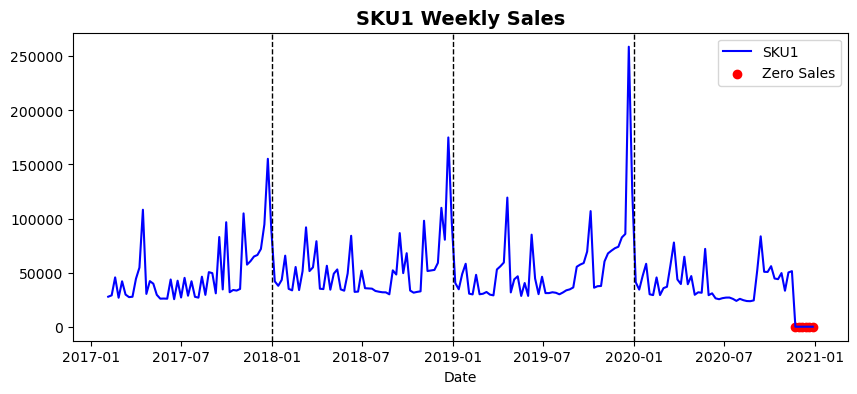

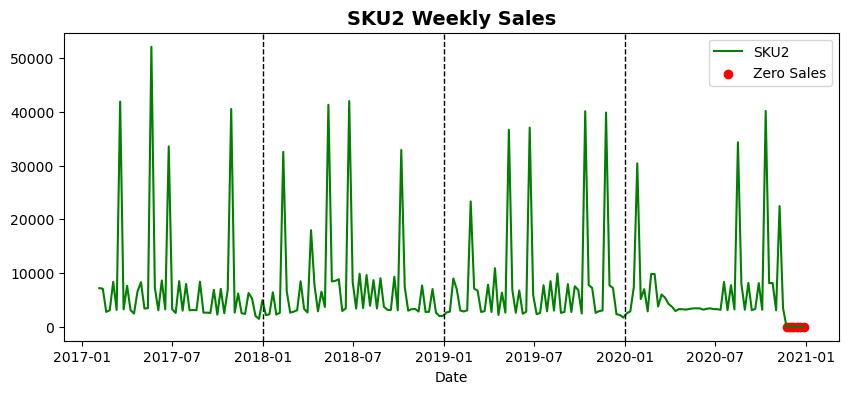

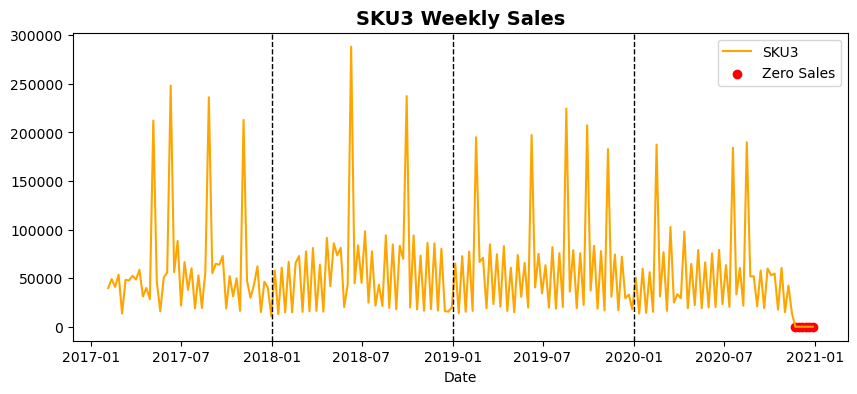

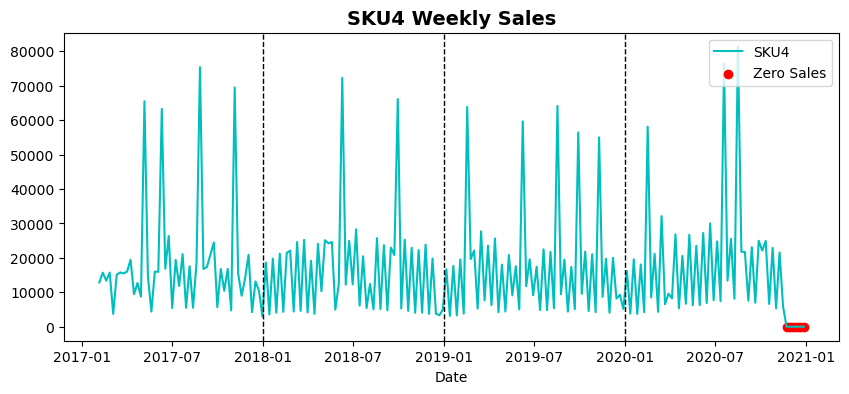

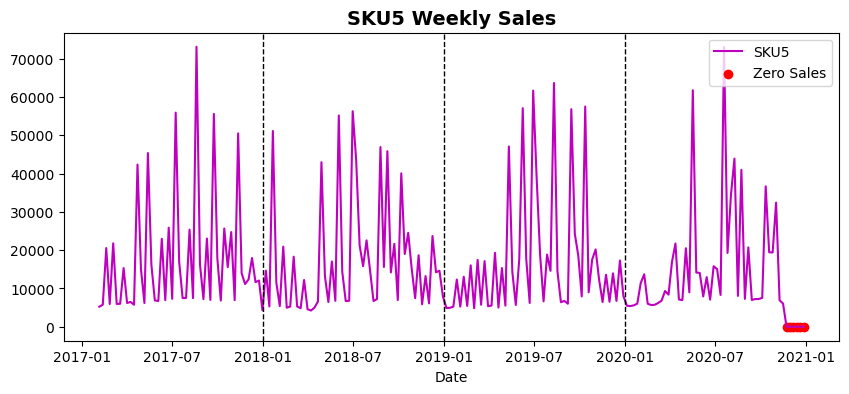

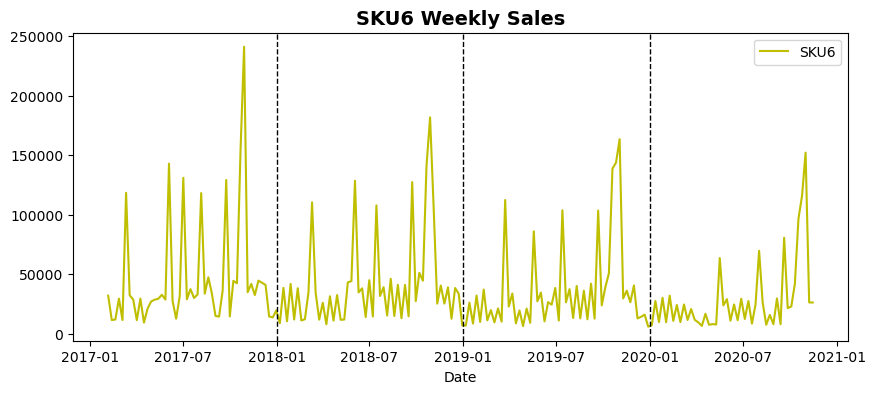

In [16]:
# Weekly sales plot for each product
#####################################
colors = ['b', 'g', 'orange', 'c', 'm', 'y']

special_dates = [datetime(2018, 1, 1), datetime(2019, 1, 1), datetime(2020, 1, 1)]

for i, product in enumerate(products):
    plt.figure(figsize=(10, 4))
    
    product_data = df[df["product"] == product]
    
    weekly_sales = product_data.groupby(pd.Grouper(key="date", freq="W")).sum()["sales"]
    
    weekly_sales = weekly_sales["2017-02-05":"2020-12-27"]
    
    plt.plot(weekly_sales.index, weekly_sales.values, label=product, color=colors[i])
    
    zero_sales = weekly_sales[weekly_sales == 0]
    if not zero_sales.empty:
        plt.scatter(zero_sales.index, zero_sales.values, color='red', marker='o', label='Zero Sales')
    
    for date in special_dates:
        plt.axvline(x=date, color='k', linestyle='--', linewidth=1)
    
    plt.legend(loc='upper right')
    
    plt.title(f"{product} Weekly Sales", fontweight="bold", fontsize=14)
    plt.xlabel("Date")
    plt.show()

In [17]:
df = df[df['date'] < '2020-11-22']

In [18]:
df['date'].max()

Timestamp('2020-11-15 00:00:00')

- In a dataset of 6 products, it is assumed that data collection has not been conducted for the last 6 weeks for 5 of them. Therefore, these weeks have been removed from the dataset. As a result, the last recorded date has been changed to **15-11-2020**.

### 2.8. Outlier detection:

In this section, we will try to identify outliers in each dataframe and take necessary actions if they exist.

In [19]:
# The function is used to calculate the outlier thresholds for a specific column in a dataframe.
################################################################
def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit


# This function is designed to check for outliers.
################################################################
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

for col in num_cols:
    print(col, check_outlier(df, col))

date False
sales True
price_discount False
google_mobility False


In [21]:
# # Grabbing outlier
################################################################
def grab_outliers(dataframe, col_name, index=False):
    low, up = outlier_thresholds(dataframe, col_name)

    outlier_df = dataframe[(dataframe[col_name] < low) | (dataframe[col_name] > up)]

    print(f"Outliers for '{col_name}':")
    if outlier_df.shape[0] > 10:
        display(outlier_df.head())
    else:
        display(outlier_df)

    if index:
        outlier_index = outlier_df.index
        return outlier_index

    return outlier_df.shape[0]

for col in num_cols:
    grab_outliers(df, col)


Outliers for 'date':


,product,date,sales,price_discount,in_store_promo,catalogue_promo,store_end_promo,google_mobility,covid_flag,v_day,easter,christmas


Outliers for 'sales':


,product,date,sales,price_discount,in_store_promo,catalogue_promo,store_end_promo,google_mobility,covid_flag,v_day,easter,christmas
150,SKU1,2019-12-22,258874,0.440,0,1,1,0.000,0,0,0,0
421,SKU3,2017-05-07,212245,0.500,1,0,0,0.000,0,0,0,0
426,SKU3,2017-06-11,248373,0.500,1,0,1,0.000,0,0,0,0
437,SKU3,2017-08-27,236242,0.500,1,0,1,0.000,0,0,0,0
447,SKU3,2017-11-05,212947,0.500,1,0,1,0.000,0,0,0,0
478,SKU3,2018-06-10,288322,0.500,1,0,1,0.000,0,0,0,0
494,SKU3,2018-09-30,237462,0.500,1,0,1,0.000,0,0,0,0
540,SKU3,2019-08-18,224723,0.520,1,0,1,0.000,0,0,0,0
1058,SKU6,2017-10-29,241114,0.530,1,0,0,0.000,0,0,0,0


Outliers for 'price_discount':


,product,date,sales,price_discount,in_store_promo,catalogue_promo,store_end_promo,google_mobility,covid_flag,v_day,easter,christmas


Outliers for 'google_mobility':


,product,date,sales,price_discount,in_store_promo,catalogue_promo,store_end_promo,google_mobility,covid_flag,v_day,easter,christmas


In [25]:
# Outlier suppression function - performs outlier capping for a specific variable within a given dataframe.
################################################################
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit
    
for col in num_cols:
    replace_with_thresholds(df, col)

In [26]:
# Checking outliers for control
for col in num_cols:
    print(col, check_outlier(df, col))

date False
sales False
price_discount False
google_mobility False
